In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
import datetime
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import griddata
import cartopy.crs as ccrs

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
## Working directory
wrk_dir = '~/work/OBS/dashcams_data/plotting_for_draft_supplementary/'

# read the RBR data

In [5]:
rbr_ds = pd.read_csv(wrk_dir + '065816_20211103_1457.csv',header=15)

In [6]:
rbr_ds.columns = rbr_ds.columns.str.strip()

rbr_ds

,//Time(yyyy-mm-dd HH:MM:ss.FFF),Temperature(°C),Pressure(dbar),Sea_Pressure(dbar)
0,2021-11-03 14:57:23.000,17.1003,10.0899,-0.0426
1,2021-11-03 14:57:23.083,17.0994,10.0912,-0.0413
2,2021-11-03 14:57:23.167,17.0964,10.0894,-0.0431
3,2021-11-03 14:57:23.250,17.0908,10.0899,-0.0426
4,2021-11-03 14:57:23.333,17.0795,10.0905,-0.0420
...,...,...,...,...
41354,2021-11-03 16:39:58.333,14.4898,10.0769,-0.0556
41355,2021-11-03 16:39:58.417,14.4955,10.0761,-0.0564
41356,2021-11-03 16:39:58.500,14.5011,10.0774,-0.0551
41357,2021-11-03 16:39:58.583,14.5049,10.0781,-0.0544


Text(0.5, 1.0, 'Temperature over Time')

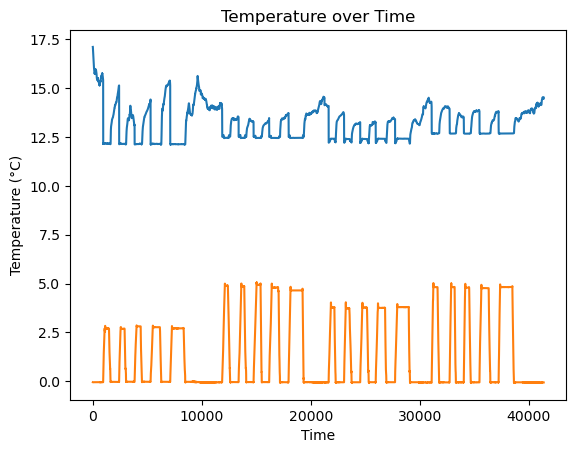

In [8]:
rbr_ds['Temperature(°C)'].plot()
rbr_ds['Sea_Pressure(dbar)'].plot()
# rbr_ds.plot(x='//Time(yyyy-mm-dd HH:MM:ss.FFF)', y='Sea_Pressure(dbar)')

# plt.xlim(1100, 1300)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature over Time')
# plt.show()

In [9]:
index_change = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])))[0]
index_change_start = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])) > 0)[0]
index_change_end = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])) < 0)[0]
index_change_start


array([  948,  2410,  3831,  5298,  7099, 11859, 13371, 14744, 16173,
       17953, 21629, 23043, 23045, 24525, 25946, 27721, 31078, 32723,
       34025, 35463, 37219])

In [10]:
index_change_end

array([ 1622,  3048,  4506,  6278,  8473, 12594, 14069, 15493, 17164,
       19334, 22267, 23044, 23732, 25301, 26925, 29085, 31764, 33299,
       34664, 36459, 38620])

948 1622


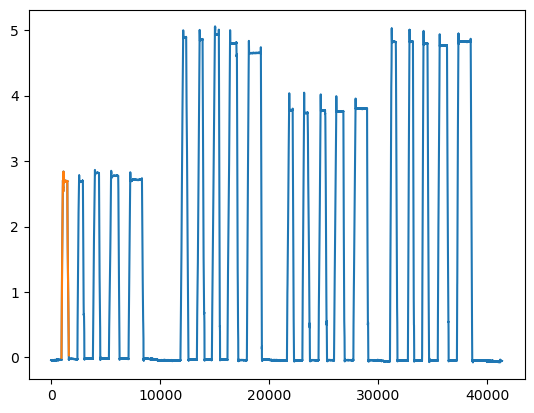

In [11]:
rbr_ds['Sea_Pressure(dbar)'].plot()

for istart, iend in zip(index_change_start, index_change_end):
    print(istart, iend)
    rbr_ds['Sea_Pressure(dbar)'][istart:iend].plot()
    break
    # plt.xlim(istart-30, iend+30)
# rbr_ds['Sea_Pressure(dbar)'][index_change_start[0]:index_change_end[0]].plot()

# plt.xlim(index_change_start[0]-30, index_change_end[0]+30)

## create rbr data to xarray

In [12]:
rbr_xr = xr.Dataset.from_dataframe(rbr_ds)

rbr_xr = xr.Dataset(
    {
        'Temperature(°C)': ('time', rbr_ds['Temperature(°C)']),
        'Pressure(dbar)': ('time', rbr_ds['Pressure(dbar)']),
        'Sea_Pressure(dbar)': ('time', rbr_ds['Sea_Pressure(dbar)'])
    },
    coords={
        'time': pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'])
    }
)
rbr_xr

<xarray.Dataset>
Dimensions:             (time: 41359)
Coordinates:
  * time                (time) datetime64[ns] 2021-11-03T14:57:23 ... 2021-11...
Data variables:
    Temperature(°C)     (time) float64 17.1 17.1 17.1 17.09 ... 14.5 14.5 14.51
    Pressure(dbar)      (time) float64 10.09 10.09 10.09 ... 10.08 10.08 10.08
    Sea_Pressure(dbar)  (time) float64 -0.0426 -0.0413 ... -0.0544 -0.0549

# Read Tag data

In [28]:
tag_ds = pd.read_csv('/home/server/pi/homes/liux8/work/mnt/RBR_CTD_Casts/Ornitela_Yaquina_2021_11_03/Ornitela_casts/215437_20211105_000000.csv')
tag_ds = tag_ds.to_xarray()
tag_ds['PST_datetime'] = tag_ds.UTC_datetime.astype('datetime64[ns]') - np.timedelta64(7, 'h')


In [29]:
# Initialize the mask variable in tag_ds
tag_ds['mask'] = xr.DataArray(np.zeros(tag_ds['UTC_datetime'].shape, dtype=bool), dims=tag_ds['UTC_datetime'].dims)

iprofile=1
for istart, iend in zip(index_change_start, index_change_end):
    start_time = pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'][istart])
    end_time = pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'][iend])
    # print(start_time, end_time)
    # break
    imask = (pd.to_datetime(tag_ds['PST_datetime']) >= start_time) & (pd.to_datetime(tag_ds['PST_datetime']) <= end_time)
    tag_ds['mask'] = xr.where(imask, iprofile, tag_ds['mask'])
    # tag_ds['mask'] = xr.where(mask, True, tag_ds['mask'])
    iprofile+=1


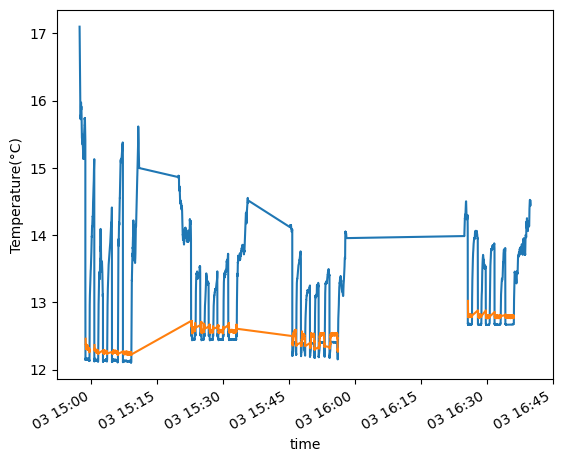

In [30]:
rbr_xr['Temperature(°C)'].plot()
plt.plot(tag_ds['PST_datetime'],tag_ds['ext_temperature_C'])

In [31]:
np.unique(tag_ds.mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [32]:
tag_ds_dives=tag_ds.where(~np.isnan(tag_ds.depth_m),drop=True)

In [33]:
np.unique(tag_ds_dives.mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

Text(0, 0.5, 'Temperature (C)')

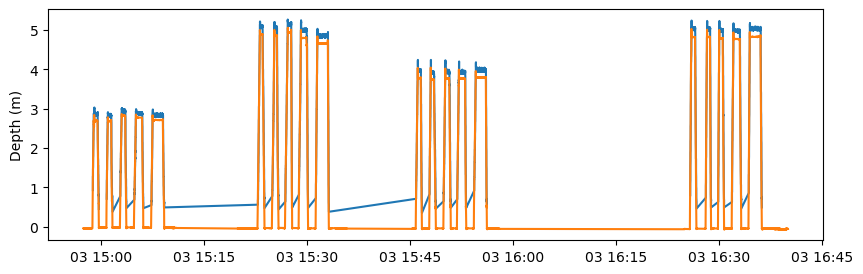

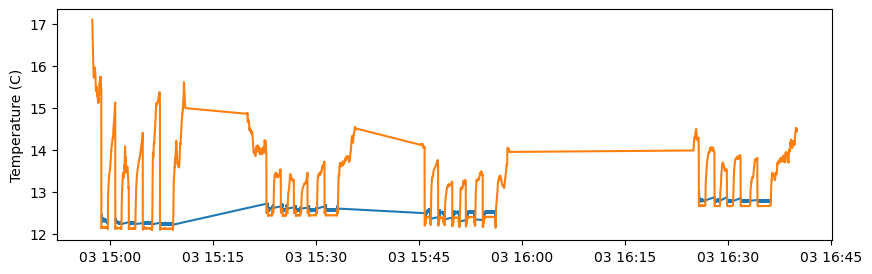

In [84]:
plt.figure(figsize=(10, 3))
plt.plot(tag_ds['PST_datetime'],tag_ds['depth_m'])
# plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])

plt.plot(pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)']),rbr_ds['Sea_Pressure(dbar)'])
plt.ylabel('Depth (m)')

plt.figure(figsize=(10, 3))
plt.plot(tag_ds['PST_datetime'],tag_ds['ext_temperature_C'])

# plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])

plt.plot(pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)']),rbr_ds['Temperature(°C)'])
# plt.xlim(start_time, end_time)
plt.ylabel('Temperature (C)')

# interpolate rbr data to the Tag grid points

## interpolate the first time

In [35]:
# # Interpolate rbr_xr to tag_ds['PST_datetime']
interpolated_rbr = rbr_xr.interp(time=tag_ds_dives['PST_datetime'].values)

interpolated_rbr

<xarray.Dataset>
Dimensions:             (time: 7194)
Coordinates:
  * time                (time) datetime64[ns] 2021-11-03T14:58:46 ... 2021-11...
Data variables:
    Temperature(°C)     (time) float64 12.15 12.15 12.15 ... 12.69 12.69 12.69
    Pressure(dbar)      (time) float64 11.39 11.39 11.39 ... 10.09 10.09 10.09
    Sea_Pressure(dbar)  (time) float64 1.258 1.258 1.258 ... -0.0455 -0.0455

(18934.62517361111, 18934.62673611111)

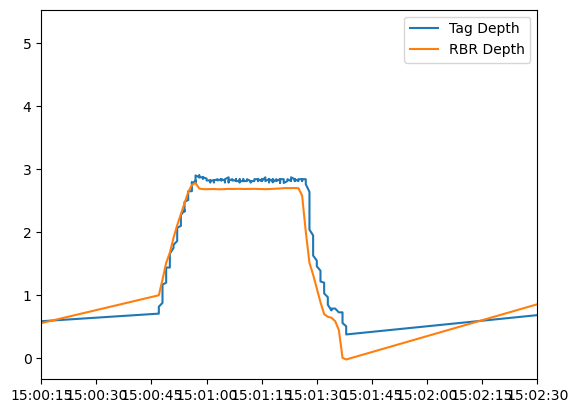

In [95]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'],label='Tag Depth')
plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'],label='RBR Depth')

plt.legend()
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlim(pd.to_datetime('2021-11-03 15:00:15'), pd.to_datetime('2021-11-03 15:02:30'))

(12.0, 12.5)

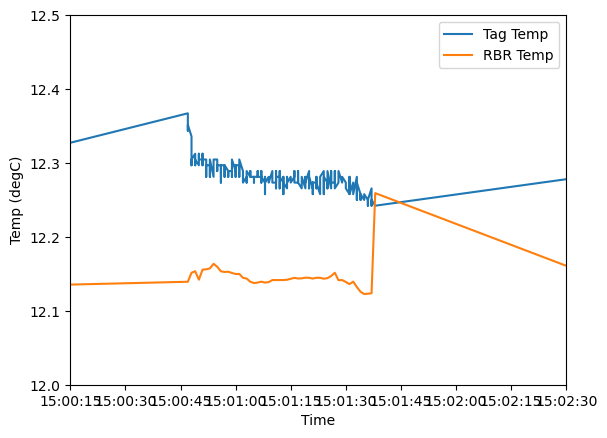

In [94]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['ext_temperature_C'],label='Tag Temp')
plt.plot(interpolated_rbr['time'],interpolated_rbr['Temperature(°C)'],label='RBR Temp')

plt.legend()
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlabel('Time')
plt.ylabel('Temp (degC)')
plt.xlim(pd.to_datetime('2021-11-03 15:00:15'), pd.to_datetime('2021-11-03 15:02:30'))
plt.ylim(12,12.5)

## calculate the lag by corvaince

In [51]:
from scipy.signal import correlate

def xcovar(x, y, maxlags):
    N = len(x)
    x = x - np.mean(x)
    y = y - np.mean(y)
    Rxy = correlate(x, y, mode='full', method='auto') / N
    lags = np.arange(-maxlags, maxlags + 1)
    Rxy = Rxy[N - 1 - maxlags:N + maxlags]
    mux = np.mean(x)
    muy = np.mean(y)
    s2x = np.var(x)
    s2y = np.var(y)
    return Rxy, mux, s2x, muy, s2y, lags

# Example usage
Drbr = interpolated_rbr['Sea_Pressure(dbar)'].values
D10Hz = tag_ds_dives['depth_m'].values
maxlags = 100

Rxy, mux, s2x, muy, s2y, lags = xcovar(Drbr, D10Hz, maxlags)
rhoxy = Rxy / np.sqrt(s2x * s2y)
vl = np.max(rhoxy)
idx = np.argmax(rhoxy)
lag = lags[idx]

print("Rxy:", Rxy)
print("mux:", mux)
print("s2x:", s2x)
print("muy:", muy)
print("s2y:", s2y)
print("lags:", lags)
print("rhoxy:", rhoxy)
print("vl:", vl)
print("idx:", idx)
print("lag:", lag)

Rxy: [0.08682958 0.09440125 0.10231215 0.11056821 0.11917938 0.12812964
 0.13744994 0.1471083  0.15711097 0.1674863  0.17823795 0.18932174
 0.20078459 0.21260488 0.22482167 0.23746752 0.25048759 0.26398062
 0.27785419 0.29220352 0.30701142 0.32224305 0.3379575  0.35405912
 0.3706052  0.38758029 0.40498747 0.42282578 0.44110751 0.45982605
 0.4789659  0.498518   0.51854233 0.53896867 0.55986758 0.58117046
 0.60293797 0.62511614 0.64775118 0.67082214 0.69427264 0.71805494
 0.74245766 0.76719375 0.79220921 0.81745828 0.84296788 0.86894065
 0.89515514 0.92157442 0.94814228 0.97488289 1.00198662 1.02917355
 1.0564447  1.08371932 1.11098822 1.13846617 1.16589687 1.19331753
 1.22053159 1.24760075 1.27466942 1.30156    1.32823402 1.35458175
 1.38056435 1.40615885 1.43149105 1.45639196 1.480682   1.50443202
 1.52759035 1.55026637 1.57234175 1.5937149  1.61438883 1.6343128
 1.6536886  1.67223413 1.68987038 1.70664368 1.72250279 1.73751888
 1.75152796 1.76447914 1.77639254 1.78722438 1.796953   1.

In [52]:
## interpolate the second time
rbr_xr_shift = xr.Dataset.from_dataframe(rbr_ds)

rbr_xr_shift = xr.Dataset(
    {
        'Temperature(°C)': ('time', rbr_ds['Temperature(°C)']),
        'Pressure(dbar)': ('time', rbr_ds['Pressure(dbar)']),
        'Sea_Pressure(dbar)': ('time', rbr_ds['Sea_Pressure(dbar)'])
    },
    coords={
        'time': pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'])+ datetime.timedelta(seconds=-0.1*lag)
    }
)
rbr_xr_shift

# # Interpolate rbr_xr to tag_ds['PST_datetime']
interpolated_rbr_shift = rbr_xr_shift.interp(time=tag_ds_dives['PST_datetime'].values)

interpolated_rbr_shift

<xarray.Dataset>
Dimensions:             (time: 7194)
Coordinates:
  * time                (time) datetime64[ns] 2021-11-03T14:58:46 ... 2021-11...
Data variables:
    Temperature(°C)     (time) float64 12.15 12.15 12.15 ... 12.69 12.69 12.69
    Pressure(dbar)      (time) float64 11.26 11.26 11.26 ... 10.14 10.14 10.14
    Sea_Pressure(dbar)  (time) float64 1.127 1.127 1.127 ... 0.0119 0.0119

In [53]:
rbr_xr

<xarray.Dataset>
Dimensions:             (time: 41359)
Coordinates:
  * time                (time) datetime64[ns] 2021-11-03T14:57:23 ... 2021-11...
Data variables:
    Temperature(°C)     (time) float64 17.1 17.1 17.1 17.09 ... 14.5 14.5 14.51
    Pressure(dbar)      (time) float64 10.09 10.09 10.09 ... 10.08 10.08 10.08
    Sea_Pressure(dbar)  (time) float64 -0.0426 -0.0413 ... -0.0544 -0.0549

(18934.625347222223, 18934.626041666666)

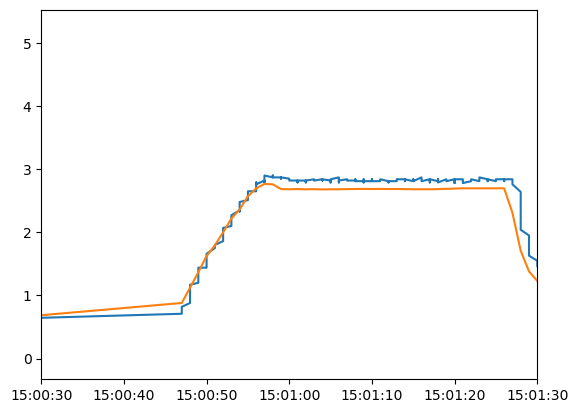

In [55]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])
plt.plot(interpolated_rbr_shift['time'],interpolated_rbr_shift['Sea_Pressure(dbar)'])
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlim(pd.to_datetime('2021-11-03 15:00:30'), pd.to_datetime('2021-11-03 15:01:30'))

# FIT the response time 

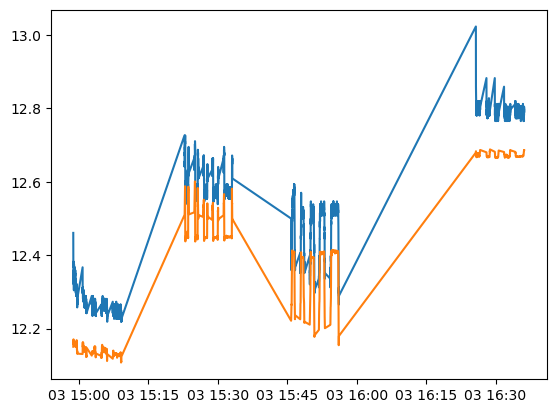

In [56]:
plt.plot(tag_ds_dives.PST_datetime,tag_ds_dives['ext_temperature_C']) 
plt.plot(interpolated_rbr_shift['time'],interpolated_rbr_shift['Temperature(°C)'])
# plt.plot(tag_ds_dives['ext_temperature_C'].values-interpolated_rbr_shift['Temperature(°C)'].values)

In [78]:
np.unique(tag_ds_dives.mask)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

12.156143445692885
12.143620622568093
12.136394756554308
12.139689567430024
12.128323362831857


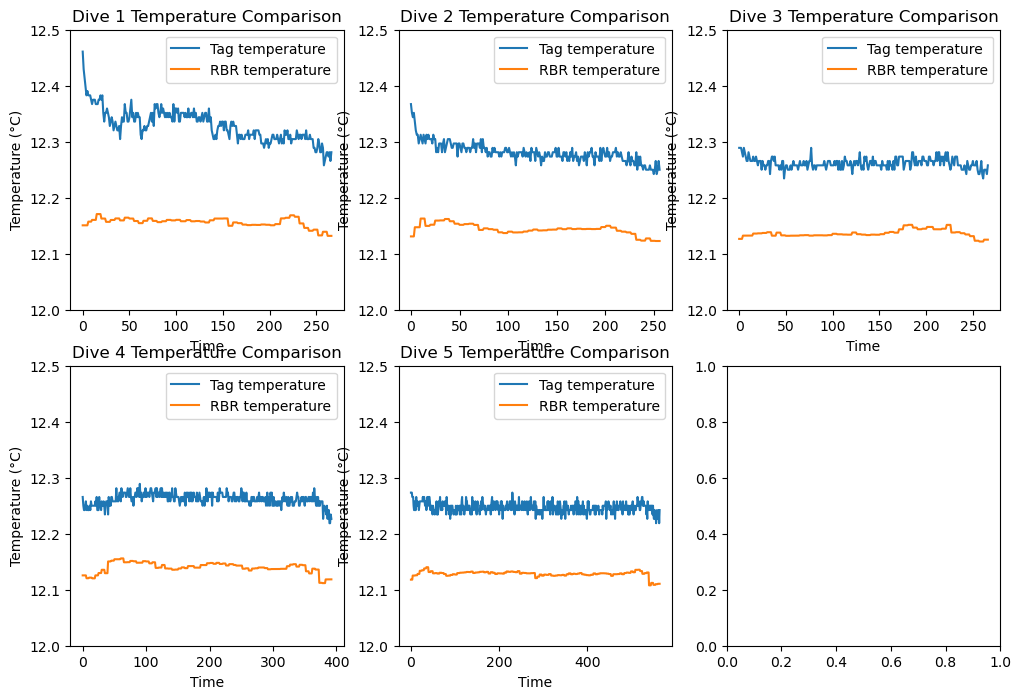

In [83]:
### dive =1
# idive=1
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for idive in range(1,6):

    interpolated_rbr_shift = interpolated_rbr_shift.assign(mask=('time', tag_ds_dives['mask'].values))

    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)
    # plt.plot(tag_dive.PST_datetime,tag_dive.ext_temperature_C)

    print(np.mean(rbr_dive_1['Temperature(°C)'].values))
    plt.subplot(2, 3, idive)
    # plt.figure(figsize=(4, 3))
    # rbr_dive_1['Temperature(°C)'].plot()
    plt.plot(tag_dive.ext_temperature_C.values, label="Tag temperature")
    plt.plot(rbr_dive_1['Temperature(°C)'], label="RBR temperature")
    plt.ylim(12,12.5)
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Dive {idive} Temperature Comparison')
    plt.legend()

    # plt.plot(tag_dive.ext_temperature_C.values-rbr_dive_1['Temperature(°C)'])
# rbr_dive_1['Sea_Pressure(dbar)'].plot()

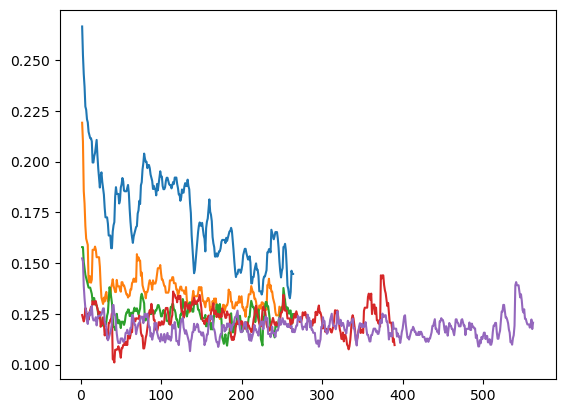

In [96]:
### dive =1
# idive=1
for idive in range(1,6):

    interpolated_rbr_shift = interpolated_rbr_shift.assign(mask=('time', tag_ds_dives['mask'].values))

    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    tag_temp_running_mean = tag_dive.ext_temperature_C.rolling(index=5, center=True).mean()
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)
    # plt.plot(tag_dive.PST_datetime,tag_dive.ext_temperature_C)

    # rbr_dive_1['Temperature(°C)'].plot()
    # plt.plot(tag_dive.ext_temperature_C.values)

    plt.plot(tag_temp_running_mean.values-rbr_dive_1['Temperature(°C)'])
# rbr_dive_1['Sea_Pressure(dbar)'].plot()

Estimated Response Time (tau): 71.98 seconds
Estimated Response Time (tau): 142.18 seconds
Estimated Response Time (tau): 330.57 seconds
Estimated Response Time (tau): -2408.13 seconds
Estimated Response Time (tau): 7069.29 seconds


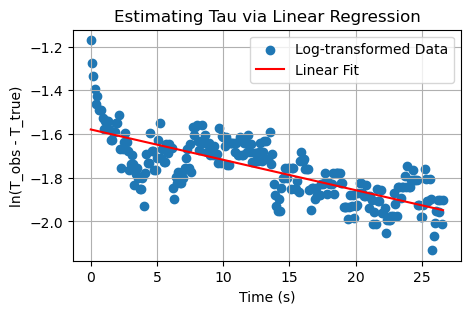

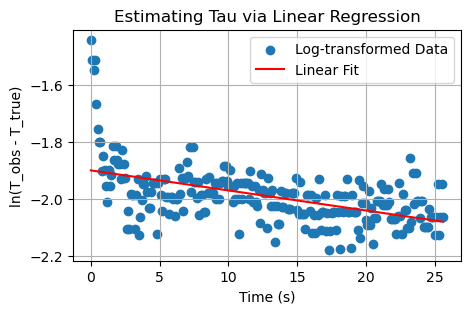

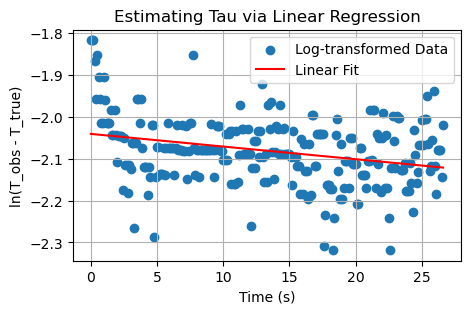

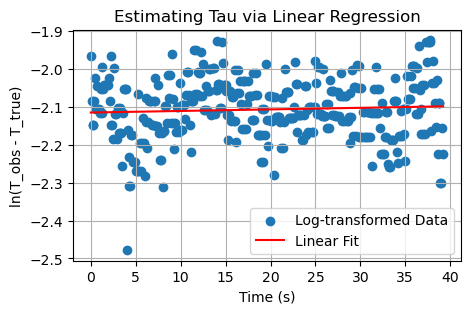

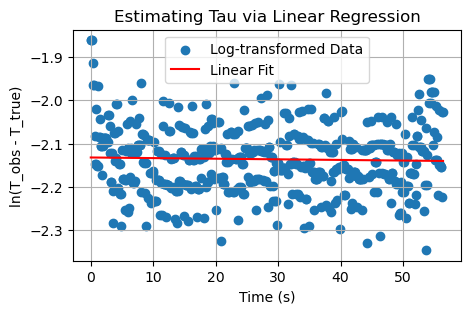

In [ ]:
for idive in range(1,6):
    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)

    t_obs = np.arange(tag_dive.ext_temperature_C.size)*0.1

    T_obs =  tag_dive.ext_temperature_C.values # Observed temperatures
    T_true = rbr_dive_1['Temperature(°C)'].values  # True water temperature
    T0 = T_obs[0]  # Initial temperature of sensor

    # Compute log-transformed values
    log_values = np.log(T_obs - T_true)

    # Perform linear regression
    slope, intercept, r_value, _, _ = linregress(t_obs, log_values)

    # Estimate tau
    tau_estimated = -1 / slope

    # Plot the transformed data and fitted line
    plt.figure(figsize=(5, 3))
    plt.scatter(t_obs, log_values, label="Log-transformed Data")
    plt.plot(t_obs, intercept + slope * t_obs, color='r', label="Linear Fit")
    plt.xlabel("Time (s)")
    plt.ylabel("ln(T_obs - T_true)")
    plt.title("Estimating Tau via Linear Regression")
    plt.legend()
    plt.grid()

    print(f"Estimated Response Time (tau): {tau_estimated:.2f} seconds")


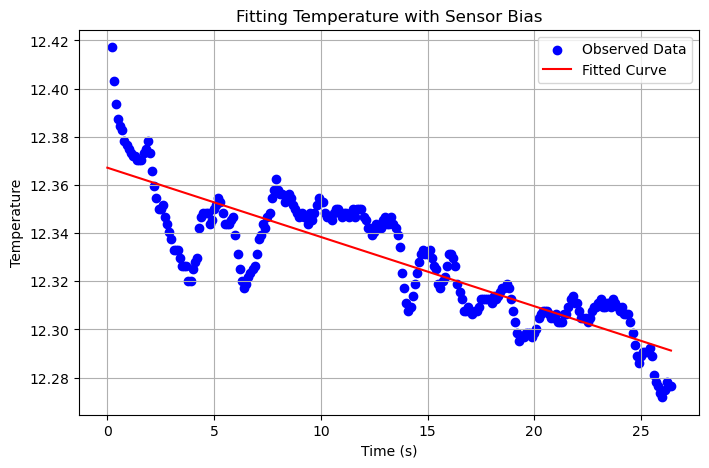

Estimated True Water Temperature: -425.69
Estimated Response Time (tau): 152337.34 seconds
Estimated Bias (eta): -0.05


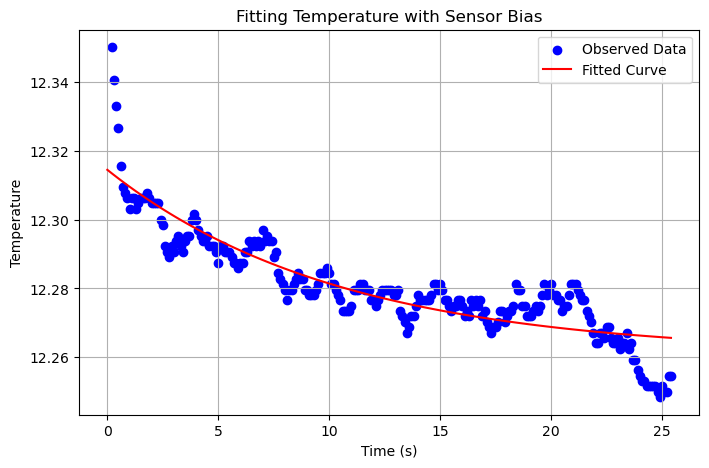

Estimated True Water Temperature: 12.30
Estimated Response Time (tau): 10.39 seconds
Estimated Bias (eta): -0.04


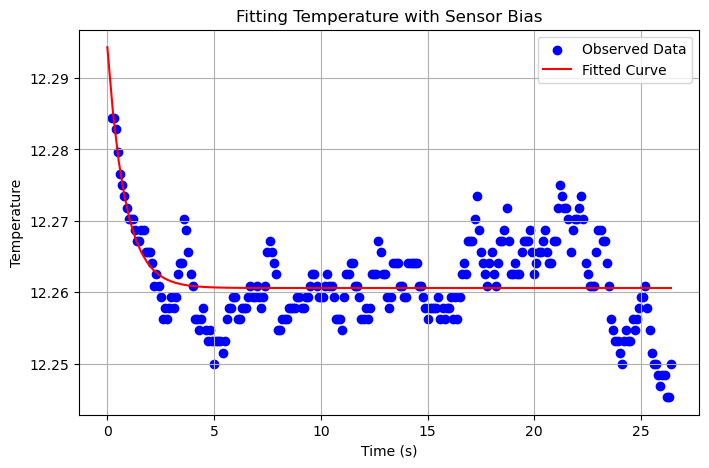

Estimated True Water Temperature: 12.25
Estimated Response Time (tau): 0.83 seconds
Estimated Bias (eta): 0.01


/tmp/ipykernel_231871/3049822889.py:22: RuntimeWarning: overflow encountered in exp
  return T_true + (T0 - T_true) * np.exp(-t / tau) + eta


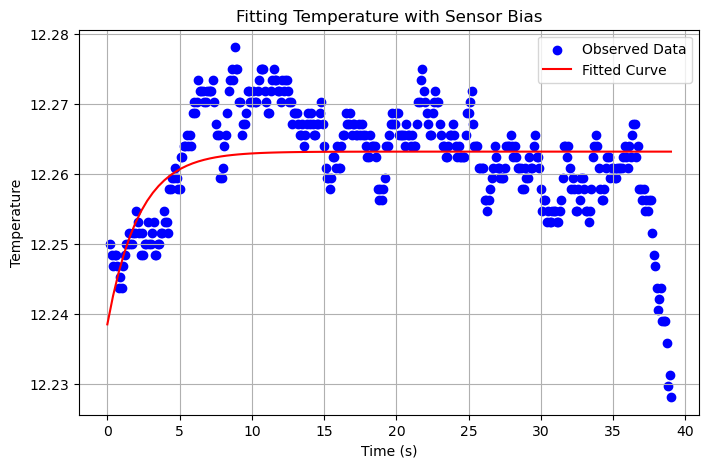

Estimated True Water Temperature: 12.27
Estimated Response Time (tau): 2.20 seconds
Estimated Bias (eta): -0.01


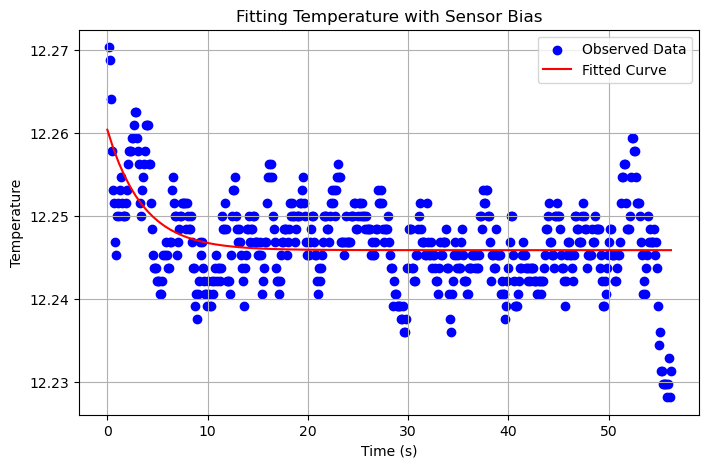

Estimated True Water Temperature: 12.26
Estimated Response Time (tau): 3.55 seconds
Estimated Bias (eta): -0.01


In [75]:
for idive in range(1,6):
    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)

    t_obs = np.arange(tag_dive.ext_temperature_C.size)*0.1
    t_obs = t_obs[2:-2]

    # T_obs =  tag_dive.ext_temperature_C.values # Observed temperatures
    T_obs =  tag_dive.ext_temperature_C.rolling(index=5, center=True).mean().dropna('index').values

    T_true = rbr_dive_1['Temperature(°C)'].values[2:-2]  # True water temperature

    # Example dataset (replace with actual data)
    # t_obs = np.array([1, 2, 3, 4, 5])  # Time after immersion
    # T_obs = np.array([15.2, 18.3, 19.8, 20.4, 20.9])  # Observed temperatures
    T0 = T_obs[0]  # Initial temperature of sensor
    T_true_guess = 21.0  # Initial guess for true temperature
    eta_guess = 0.5  # Initial guess for bias

    # Define the nonlinear model including bias
    def temperature_model(t, T_true, tau, eta):
        return T_true + (T0 - T_true) * np.exp(-t / tau) + eta

    # Initial parameter guesses: (T_true, tau, eta)
    initial_guess = [T_true_guess, 5.0, eta_guess]

    # Fit the model
    popt, pcov = curve_fit(temperature_model, t_obs, T_obs, p0=initial_guess)

    # Extract fitted parameters
    T_true_fit, tau_fit, eta_fit = popt

    # Plot observed vs. fitted
    t_fit = np.linspace(0, max(t_obs), 100)
    T_fit = temperature_model(t_fit, *popt)

    plt.figure(figsize=(8, 5))
    plt.scatter(t_obs, T_obs, label="Observed Data", color="b")
    plt.plot(t_fit, T_fit, label="Fitted Curve", color="r")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.title("Fitting Temperature with Sensor Bias")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated True Water Temperature: {T_true_fit:.2f}")
    print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
    print(f"Estimated Bias (eta): {eta_fit:.2f}")


In [72]:
T_obs

array([       nan,        nan, 12.4171875, 12.403125 , 12.39375  ,
       12.3875   , 12.384375 , 12.3828125, 12.378125 , 12.3765625,
       12.375    , 12.3734375, 12.371875 , 12.371875 , 12.3703125,
       12.3703125, 12.3703125, 12.3734375, 12.375    , 12.378125 ,
       12.3734375, 12.365625 , 12.359375 , 12.3546875, 12.35     ,
       12.35     , 12.3515625, 12.346875 , 12.34375  , 12.340625 ,
       12.3375   , 12.3328125, 12.3328125, 12.3328125, 12.3296875,
       12.3265625, 12.3265625, 12.3265625, 12.3203125, 12.3203125,
       12.325    , 12.328125 , 12.3296875, 12.3421875, 12.346875 ,
       12.3484375, 12.3484375, 12.3484375, 12.34375  , 12.3453125,
       12.35     , 12.3515625, 12.3546875, 12.353125 , 12.3484375,
       12.34375  , 12.34375  , 12.34375  , 12.3453125, 12.346875 ,
       12.3390625, 12.33125  , 12.325    , 12.3203125, 12.3171875,
       12.31875  , 12.321875 , 12.3234375, 12.325    , 12.3265625,
       12.33125  , 12.3375   , 12.3390625, 12.34375  , 12.3421

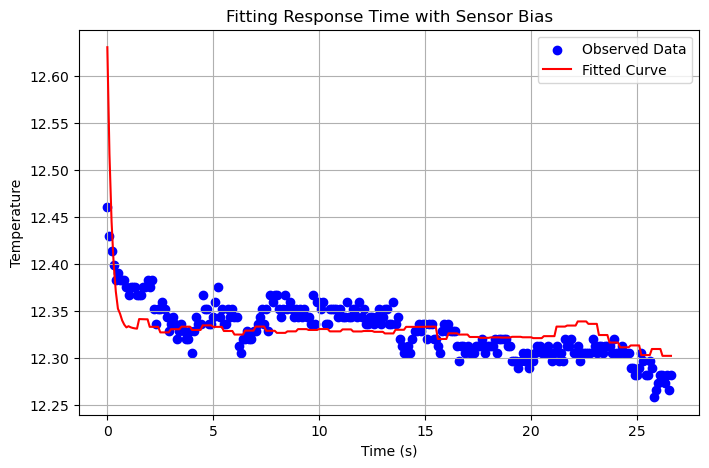

Estimated Response Time (tau): 0.22 seconds
Estimated Bias (eta): 0.17


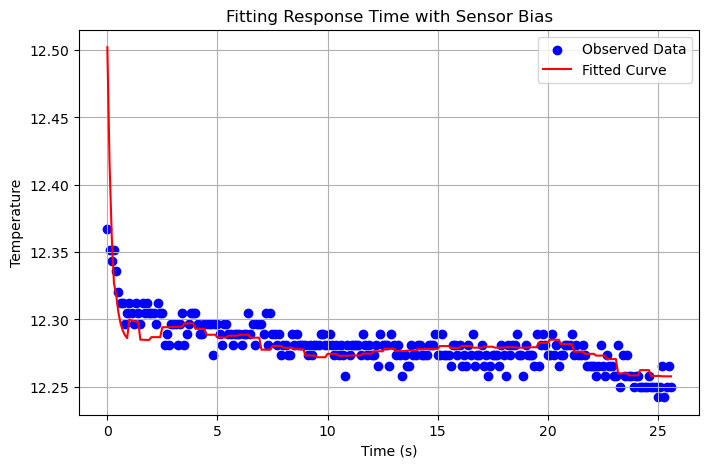

Estimated Response Time (tau): 0.22 seconds
Estimated Bias (eta): 0.14


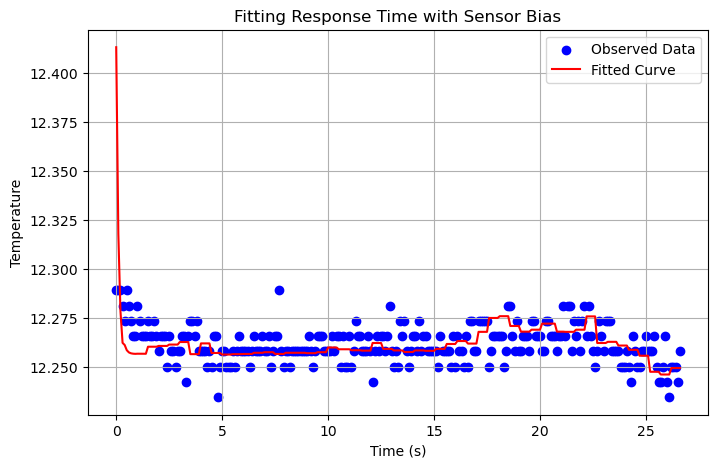

Estimated Response Time (tau): 0.11 seconds
Estimated Bias (eta): 0.12


/tmp/ipykernel_231871/2732927186.py:18: RuntimeWarning: overflow encountered in exp
  return T_true + (T0 - T_true) * np.exp(-t / tau) + eta
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


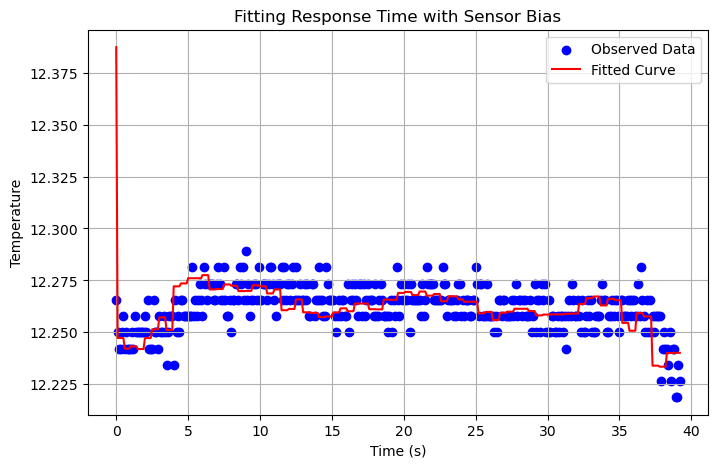

Estimated Response Time (tau): 0.00 seconds
Estimated Bias (eta): 0.12


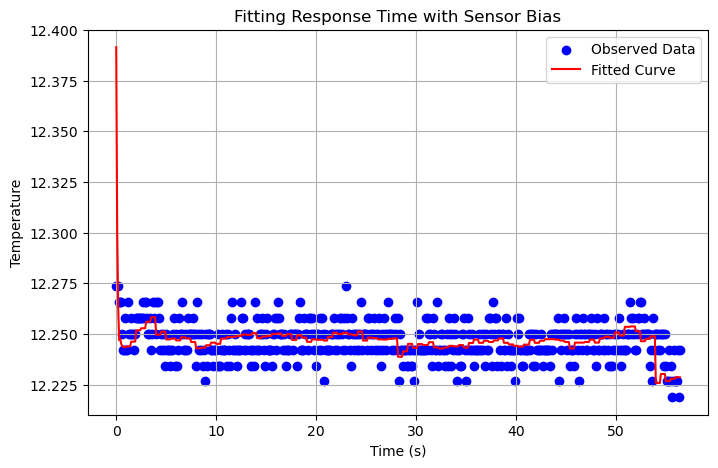

Estimated Response Time (tau): 0.11 seconds
Estimated Bias (eta): 0.12


In [97]:
for idive in range(1,6):
    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)

    t_obs = np.arange(tag_dive.ext_temperature_C.size)*0.1

    T_obs =  tag_dive.ext_temperature_C.values # Observed temperatures
    T_true = rbr_dive_1['Temperature(°C)'].values  # True water temperature

    # Example dataset (replace with actual data)
    # t_obs = np.array([1, 2, 3, 4, 5])  # Time after immersion (seconds)
    # T_obs = np.array([15.2, 18.3, 19.8, 20.4, 20.9])  # Observed temperatures
    # T_true = np.array([21.0, 21.0, 21.0, 21.0, 21.0])  # Known true temperatures
    T0 = T_obs[0]  # First recorded observed temperature

    # Define the fitting function
    def temperature_model(t, tau, eta):
        return T_true + (T0 - T_true) * np.exp(-t / tau) + eta

    # Initial guesses for tau and eta
    initial_guess = [5.0, 0.5]  # Guess tau=5s, eta=0.5

    # Fit the model
    popt, pcov = curve_fit(temperature_model, t_obs, T_obs, p0=initial_guess)

    # Extract fitted parameters
    tau_fit, eta_fit = popt

    # Generate fitted curve
    t_fit = t_obs
    T_fit = temperature_model(t_fit, *popt)

    # Plot observed vs. fitted
    plt.figure(figsize=(8, 5))
    plt.scatter(t_obs, T_obs, label="Observed Data", color="b")
    plt.plot(t_fit, T_fit, label="Fitted Curve", color="r")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.title("Fitting Response Time with Sensor Bias")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
    print(f"Estimated Bias (eta): {eta_fit:.2f}")


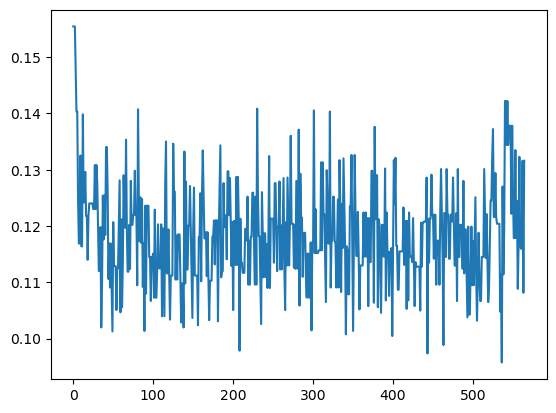

In [60]:
plt.plot(tag_dive.ext_temperature_C.values-rbr_dive_1['Temperature(°C)'].values)

In [97]:
np.unique(interpolated_rbr_shift['mask'])

array([ 0.,  1.,  2.,  3.,  4., 10., 11., 12., 13., 14., 15., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [50]:
interpolated_rbr_shift['Temperature(°C)'].values-tag_ds_dives['ext_temperature_C'].values

array([-3.35164286, -3.10945536, -2.92976786, ..., -0.11258929,
       -0.10477679, -0.10477679])

In [102]:
rbr_dive_1

<xarray.Dataset>
Dimensions:             (time: 510)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T15:07:47 ... 2020-11...
    mask                (time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
Data variables:
    Temperature(°C)     (time) float64 11.26 11.26 11.26 ... 11.34 11.34 11.34
    Pressure(dbar)      (time) float64 11.46 11.46 11.46 ... 10.94 10.94 10.94
    Sea_Pressure(dbar)  (time) float64 1.332 1.332 1.332 ... 0.8097 0.8097